In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Concatenate, Dropout, Flatten, LSTM, Bidirectional, GRU
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
import emoji
import ast
# import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [31]:
data = pd.read_csv('tweets_final.csv')
# data.loc[data['relevant'] == False, 'type'] = 'none'
data.replace({'type': {'general': 'none', 'all': 'multiple'}}, inplace=True)
data

,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,[],NaN,NaN
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['https://ubm.io/2MCQwfg'],https://www.darkreading.com/endpoint-security,False
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['http://quantus.biz/security/2018/08/30/crypt...,http://www.quantusintel.group/,True
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://addons.prestashop.com/en/23513-anti-d...,https://addons.prestashop.com/en/23513-anti-dd...,True
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://www.hotelmanagement.net/tech/data-lea...,http://www.hotelmanagement.net/tech/data-leak-...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
21363,b'5b982924bb325e3cadebf9ad',2018-09-11 20:44:19+00:00,1039615645883789313,False,@FuddBot (cont'd) ... Spikes in tweet volume: ...,{'created_at': 'Tue Sep 11 20:44:19 +0000 2018...,botnet,"{'usage': {'text_units': 1, 'text_characters':...",business,['https://twitter.com/i/web/status/10396156458...,https://twitter.com/i/web/status/1039615645883...,True
21364,b'5b982928bb325e3cadebf9ae',2018-09-11 20:44:24+00:00,1039615665584259072,True,@NarutoRomania ransomware content blackmail fo...,{'created_at': 'Tue Sep 11 20:44:24 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",threat,[],NaN,NaN
21365,b'5b982929bb325e3cadebf9af',2018-09-11 20:44:25+00:00,1039615668814077954,True,Make sure you have upgraded to #tor 8.0 #priva...,{'created_at': 'Tue Sep 11 20:44:25 +0000 2018...,none,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://www.neowin.net/news/zerodium-an-expl...,https://www.neowin.net/news/zerodium-an-exploi...,True
21366,b'5b98294abb325e3cadebf9b0',2018-09-11 20:44:58+00:00,1039615806303133696,False,@JennMGreenberg @MindingTheKings I was thinkin...,{'created_at': 'Tue Sep 11 20:44:58 +0000 2018...,none,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,['https://twitter.com/i/web/status/10396158063...,https://twitter.com/i/web/status/1039615806303...,True


In [13]:
# Load data from CSV file
data = pd.read_csv('tweets_final.csv')
# data.loc[data['relevant'] == False, 'type'] = 'none'
data.replace({'type': {'general': 'none', 'all': 'multiple'}}, inplace=True)

# Message Structure preprocessing
# Extract structural features (Table 1)
# Define the function to extract structural features (Table 1)
def extract_structural_features(text):
    # Implement feature extraction logic
    message_length = len(text)
    num_tokens = len(word_tokenize(text))
    num_hashtags = text.count('#')
    num_emails = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    num_urls = text.count('http://') + text.count('https://')
    num_periods = text.count('.')
    num_commas = text.count(',')
    num_digits = sum(c.isdigit() for c in text)
    num_sentences = len(sent_tokenize(text))
    num_mentioned_users = text.count('@')
    num_uppercase = sum(c.isupper() for c in text)
    num_question_marks = text.count('?')
    num_exclamation_marks = text.count('!')
    emojis = set(re.findall(r'\:[\w]+\:', emoji.demojize(text)))
    num_emoticons = len(emojis)
    num_dollar_symbols = text.count('$')
    # Other symbols
    num_other_symbols = len([char for char in text if char not in '"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!' + ''.join(emojis)])
    # Return features as a list
    return [message_length, num_tokens, num_hashtags, num_emails, num_urls, num_periods, num_commas, num_digits, num_sentences, num_mentioned_users, num_uppercase, num_question_marks, num_exclamation_marks, num_emoticons, num_dollar_symbols, num_other_symbols]

# Apply the function to extract structural features and create a new column
data['structural_features'] = data['text'].apply(extract_structural_features)

# Stopwords removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

data['text'] = data['text'].apply(remove_stopwords)

# Define the function to replace specific text components with predefined tokens
def replace_text_components(text):
    # Implement text component replacement logic
    # For example, replace email addresses with 'email_nlp', replace mentioned users with 'at_user_nlp', etc.
    # Here's a simple example:
    text = text.replace('.', '_period_')
    text = text.replace('/', '_slash_')
    text = text.replace('@', '_at_')
    text = text.replace('-', '_hyphen_')
    text = text.replace(':', '_colon_')
    text = text.replace('#', '')  # Remove hashtags
    # Add more replacement rules as needed
    return text

data['text'] = data['text'].apply(replace_text_components)

# Data Preprocessing
# Data Cleaning
def clean_text(text):
    # Remove unnecessary characters
    text = re.sub(r'[^\w\s]', '', text)
    # Replace repetitive line breaks and blank spaces with only one
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove emoticons and emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['text'] = data['text'].apply(lemmatize_text)

# POS Tagging
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

data['pos_tags'] = data['text'].apply(pos_tagging)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
X_seq = tokenizer.texts_to_sequences(data['text'])
X_pad = pad_sequences(X_seq, maxlen=500)
        
# Extract URL characteristics (Table 2) from the destination_url column
def extract_first_url(url_list):
    try:
        urls = ast.literal_eval(url_list)
        first_url = urls[0] if urls else None
        return first_url
    except (SyntaxError, ValueError):
        return None

def extract_url_features(url, urls, certificate):
    # Extract domain suffix and registrant from the URL
    if pd.isna(url):
        return ['NA'] * 24  # Return NA for all features if URL is missing
    else:
        url_length = len(url)
        has_security_protocol = 1 if url.startswith(('http://', 'https://')) else 0
        # Feature 3 and 4: Creation date and Last update date (Days) - Not implemented
        # Extract the first URL from the list
        first_url = extract_first_url(urls)
        is_shortened_url = 1 if first_url and len(url) < len(first_url) else 0
        strings_divided_by_periods = len(url.split('.'))
        strings_divided_by_hyphens = len(url.split('-'))
        strings_divided_by_slashes = len(url.split('/'))
        num_words = len(re.findall(r'\b\w+\b', url))
        num_ips = len(re.findall(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', url))
        num_digits = sum(c.isdigit() for c in url)
        num_hyphens = url.count('-')
        num_periods = url.count('.')
        num_slashes = url.count('/')
        num_uppercase = sum(c.isupper() for c in url)
        num_lowercase = sum(c.islower() for c in url)
        num_ampersand_symbols = url.count('&')
        num_equal_symbols = url.count('=')
        num_question_marks = url.count('?')
        num_wave_symbols = url.count('~')
        num_plus_signs = url.count('+')
        num_colon_symbols = url.count(':')
        num_other_characters = len([char for char in url if char not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!-'])
        has_extension = 1 if '.' in url else 0
        domain_suffix = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-1] if '/' in url else 'NA'
        registrant = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-2] if '/' in url else 'NA'
        if 'utm' in registrant:
            print(url)
        valid_certificate = 1 if certificate else 0
        return [url_length, has_security_protocol, is_shortened_url, strings_divided_by_periods, strings_divided_by_hyphens, strings_divided_by_slashes, num_words, num_ips, num_digits, num_hyphens, num_periods, num_slashes, num_uppercase, num_lowercase, num_ampersand_symbols, num_equal_symbols, num_question_marks, num_wave_symbols, num_plus_signs, num_colon_symbols, num_other_characters, has_extension, domain_suffix, registrant, valid_certificate]

# Apply the function to the 'destination_url' column and create new columns for each feature
# data['url_features'] = data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1)

# Replace specific URL components with predefined tokens
def replace_url_components(url):
    # Replace email addresses and mentioned users with predefined tokens
    replaced_url = re.sub(r'[\w\.-]+@[\w\.-]+', 'email_nlp', url)
    replaced_url = re.sub(r'@[\w\.-]+', 'at_user_nlp', replaced_url)
    return replaced_url

# Replace NaN values with an empty string in the 'destination_url' column
data.fillna({'destination_url': ''}, inplace=True)
# Replace URL components with predefined tokens
data['resolved_urls'] = data['destination_url'].apply(replace_url_components)

In [14]:
# Get dataframe of URL features using extract_url_features on data
url_structure_df = pd.DataFrame(data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1, result_type='expand'))
url_structure_df.columns = ['url_length', 'has_security_protocol', 'is_shortened_url', 'strings_divided_by_periods', 'strings_divided_by_hyphens', 'strings_divided_by_slashes', 'num_words', 'num_ips', 'num_digits', 'num_hyphens', 'num_periods', 'num_slashes', 'num_uppercase', 'num_lowercase', 'num_ampersand_symbols', 'num_equal_symbols', 'num_question_marks', 'num_wave_symbols', 'num_plus_signs', 'num_colon_symbols', 'num_other_characters', 'has_extension', 'domain_suffix', 'registrant', 'valid_certificate']

# Convert the 'domain_suffix' and 'registrant' columns from categorical to numerical using hashmaps
url_hasher = FeatureHasher(n_features=(url_structure_df['domain_suffix'].nunique() + url_structure_df['registrant'].nunique()), input_type='string')
data['url_features'] = url_hasher.fit_transform(url_structure_df[['domain_suffix', 'registrant']].values.tolist()).toarray().tolist()

In [15]:
X_text_structure = np.array(data['structural_features'].tolist())
X_url_structure = np.array(data['url_features'].tolist())

label_dict = {'none': 0, 'vulnerability': 1, 'ransomware': 2, 'ddos': 3, 'leak': 4, 'general': 5, '0day': 6, 'botnet': 7, 'multiple': 8}
y = np.array([label_dict[category] for category in data['type']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)
# X_train_hash, X_test_hash, _, _ = train_test_split(X_hash, y, test_size=0.2, random_state=42)
X_train_text_structure, X_test_text_structure, _, _ = train_test_split(X_text_structure, y, test_size=0.2, random_state=42)
X_train_url_structure, X_test_url_structure, _, _ = train_test_split(X_url_structure, y, test_size=0.2, random_state=42)

In [38]:
X_text_structure.shape, X_url_structure.shape, X_pad.shape

((21368, 16), (21368, 1336), (21368, 500))

In [39]:
# Build the CNN model
input_content = Input(shape=(500,), name='content_input')
input_text_structure = Input(shape=(16,), name='text_structure_input')
input_url_structure = Input(shape=(1336,), name='url_structure_input')

# Additional input layers for other features
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=100)(input_content)
conv_layer = Conv1D(128, 5, activation='relu')(embedding)
dropout_layer = Dropout(rate=0.5)(conv_layer)
pooling_layer = GlobalMaxPooling1D()(dropout_layer)
flattened_layer = Flatten()(pooling_layer)

# Concatenate all input layers
concatenated_inputs = Concatenate()([flattened_layer, input_text_structure, input_url_structure])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated_inputs)
output = Dense(9, activation='softmax')(dense1)  # Output layer with 9 classes

# Define the model
model = Model(inputs=[input_content, input_text_structure, input_url_structure], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    x=[X_train, X_train_text_structure, X_train_url_structure],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(
        [X_test, X_test_text_structure, X_test_url_structure],
        y_test
    )
)

Epoch 1/5
535/535 [==============================] - 77s 140ms/step - loss: 0.5010 - accuracy: 0.8763 - val_loss: 0.2090 - val_accuracy: 0.9640
Epoch 2/5
535/535 [==============================] - 77s 144ms/step - loss: 0.1036 - accuracy: 0.9712 - val_loss: 0.1786 - val_accuracy: 0.9609
Epoch 3/5
535/535 [==============================] - 79s 148ms/step - loss: 0.0689 - accuracy: 0.9796 - val_loss: 0.1692 - val_accuracy: 0.9607
Epoch 4/5
535/535 [==============================] - 78s 146ms/step - loss: 0.0396 - accuracy: 0.9877 - val_loss: 0.1490 - val_accuracy: 0.9658
Epoch 5/5
535/535 [==============================] - 75s 140ms/step - loss: 0.0197 - accuracy: 0.9943 - val_loss: 0.1396 - val_accuracy: 0.9677


In [40]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test, X_test_text_structure, X_test_url_structure], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

model.summary()

# Make predictions on the test set
predictions = model.predict([X_test, X_test_text_structure, X_test_url_structure])
predicted_labels = np.argmax(predictions, axis=1)

134/134 [==============================] - 2s 14ms/step - loss: 0.1396 - accuracy: 0.9677
Test Loss: 0.1396307498216629, Test Accuracy: 0.9677117466926575
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 content_input (InputLayer)  [(None, 500)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']       
                                                                                                  
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']         
                                                                                                  
 dropout_1 (Dropout)         (None, 

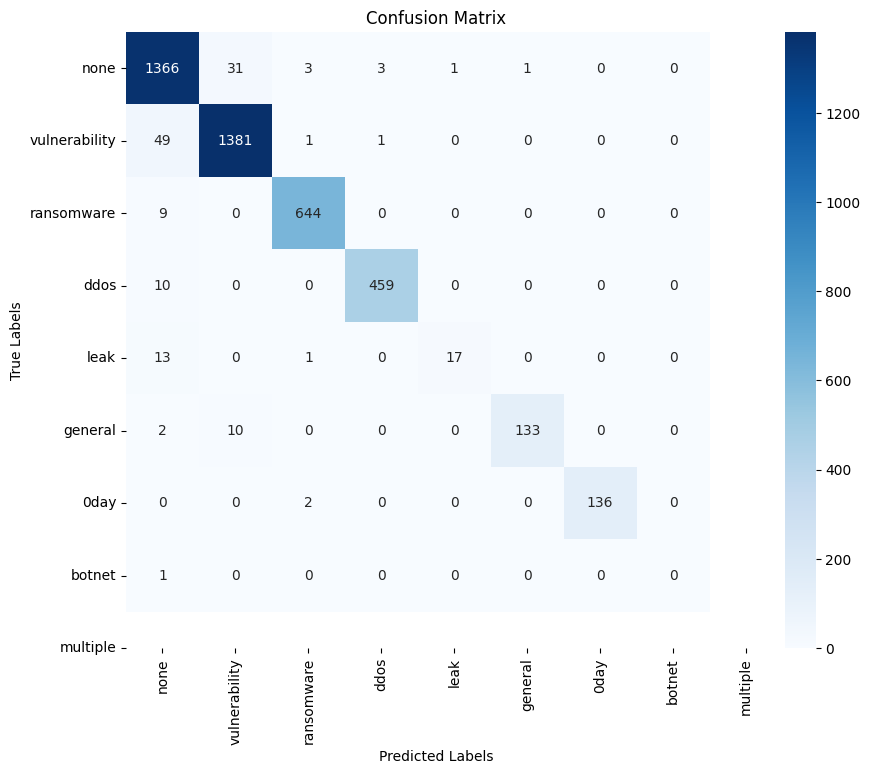

In [42]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
model.save('advanced_cnn_model.keras')

In [82]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_dict.pickle', 'wb') as handle:
    pickle.dump(label_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('url_hasher.pickle', 'wb') as handle:
    pickle.dump(url_hasher, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
random_sentence_to_test = 'Hackers exploit zero day bug. Link to the CVE: https://example.com/data'
urls_in_text = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', random_sentence_to_test)

random_sentence_to_test_text_structure = np.array([extract_structural_features(random_sentence_to_test)])
random_sentence_to_test_url_structure = extract_url_features(urls_in_text[0], urls_in_text, False)
random_sentence_to_test_url_structure = url_hasher.transform([random_sentence_to_test_url_structure[-3:-1]]).toarray()

random_sentence_to_test = remove_stopwords(random_sentence_to_test)
random_sentence_to_test = replace_text_components(random_sentence_to_test)
random_sentence_to_test = clean_text(random_sentence_to_test)
random_sentence_to_test = lemmatize_text(random_sentence_to_test)
random_sentence_to_test = tokenizer.texts_to_sequences([random_sentence_to_test])
random_sentence_to_test = pad_sequences(random_sentence_to_test, maxlen=500)

# Make predictions on the random sentence
predictions = model.predict([random_sentence_to_test, random_sentence_to_test_text_structure, random_sentence_to_test_url_structure])
predicted_label = np.argmax(predictions, axis=1)[0]
predicted_label, list(label_dict.keys())[list(label_dict.values()).index(predicted_label)]

1/1 [==============================] - 0s 39ms/step


(1, 'vulnerability')

In [53]:
from tensorflow.keras.models import load_model
model = load_model('advanced_cnn_model.keras')
model.to_json()

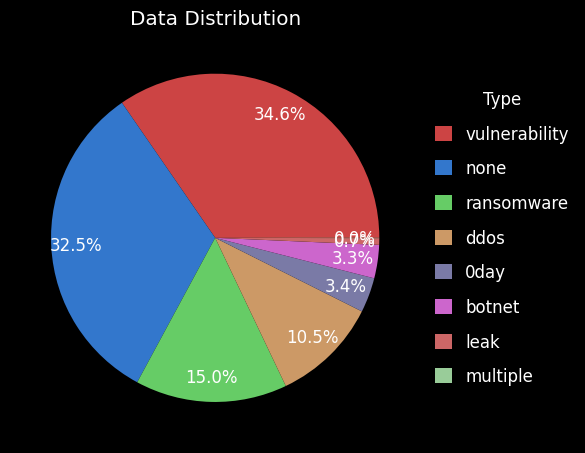

iVBORw0KGgoAAAANSUhEUgAAAlgAAAJYCAYAAAC+ZpjcAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGoP6dpAACgi0lEQVR4nOzdd3RU1drH8e/09N4LSUjovYt0RIooImAFBBtYrvVevddyBexXBQvqawUEUUFFUEER6UVAem8hBBJI7z0zc94/QkZCAglhkpNkns9as3TOnPKcIZn8Zp999tYACkIIIYQQwm60ahcghBBCCNHUSMASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQws4kYAkhhBBC2JkELCGEEEIIO5OAJYQQQghhZxKwhBBCCCHsTAKWEEIIIYSdScASQgghhLAzCVhCCCGEEHYmAUsIIYQQ

In [97]:
type_counts = data['type'].value_counts()

plt.figure(figsize=(6, 6))
plt.style.use('dark_background')
plt.rcParams['text.color'] = 'white'
plt.rcParams['font.size'] = 12

# get base64 image of the plot
import io
import base64
plt.pie(type_counts, labels=None, autopct='%1.1f%%', pctdistance=0.85, colors=['#cc4444', '#3377cc', '#66cc66', '#cc9966', '#7a7aa6', '#cc66cc', '#cc6666', '#99cc99', '#99cccc'])
plt.title('Data Distribution')
plt.legend(type_counts.index, title='Type', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
base64_img = io.BytesIO()
plt.savefig(base64_img, format='png')
base64_img.seek(0)
base64_img = base64.b64encode(base64_img.read()).decode('utf-8')
plt.show()
print(base64_img)

# Glove

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Concatenate, Dropout, Flatten
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import ast

# Load data from CSV file
data = pd.read_csv('tweets_final.csv')
data.replace({'type': {'general': 'none', 'all': 'multiple'}}, inplace=True)

# Message Structure preprocessing
def extract_structural_features(text):
    message_length = len(text)
    num_tokens = len(word_tokenize(text))
    num_hashtags = text.count('#')
    num_emails = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    num_urls = text.count('http://') + text.count('https://')
    num_periods = text.count('.')
    num_commas = text.count(',')
    num_digits = sum(c.isdigit() for c in text)
    num_sentences = len(sent_tokenize(text))
    num_mentioned_users = text.count('@')
    num_uppercase = sum(c.isupper() for c in text)
    num_question_marks = text.count('?')
    num_exclamation_marks = text.count('!')
    emojis = set(re.findall(r'\:[\w]+\:', emoji.demojize(text)))
    num_emoticons = len(emojis)
    num_dollar_symbols = text.count('$')
    num_other_symbols = len([char for char in text if char not in '"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!' + ''.join(emojis)])
    return [message_length, num_tokens, num_hashtags, num_emails, num_urls, num_periods, num_commas, num_digits, num_sentences, num_mentioned_users, num_uppercase, num_question_marks, num_exclamation_marks, num_emoticons, num_dollar_symbols, num_other_symbols]

data['structural_features'] = data['text'].apply(extract_structural_features)

# Stopwords removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

data['text'] = data['text'].apply(remove_stopwords)

# Clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['text'] = data['text'].apply(lemmatize_text)

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

# Load GloVe embeddings (adjust the file path as needed)
glove_embeddings = load_glove_embeddings('glove/glove.6B.2# Glove00d.txt')

# Prepare the embedding matrix
def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
X_seq = tokenizer.texts_to_sequences(data['text'])
X_pad = pad_sequences(X_seq, maxlen=250)

# Create the embedding matrix using GloVe embeddings
embedding_dim = 200  # Adjust based on the GloVe model you use
embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings, embedding_dim)

# Extract URL characteristics (Table 2) from the destination_url column
def extract_first_url(url_list):
    try:
        urls = ast.literal_eval(url_list)
        first_url = urls[0] if urls else None
        return first_url
    except (SyntaxError, ValueError):
        return None

def extract_url_features(url, urls, certificate):
    # Extract domain suffix and registrant from the URL
    if pd.isna(url):
        return ['NA'] * 24  # Return NA for all features if URL is missing
    else:
        url_length = len(url)
        has_security_protocol = 1 if url.startswith(('http://', 'https://')) else 0
        # Feature 3 and 4: Creation date and Last update date (Days) - Not implemented
        # Extract the first URL from the list
        first_url = extract_first_url(urls)
        is_shortened_url = 1 if first_url and len(url) < len(first_url) else 0
        strings_divided_by_periods = len(url.split('.'))
        strings_divided_by_hyphens = len(url.split('-'))
        strings_divided_by_slashes = len(url.split('/'))
        num_words = len(re.findall(r'\b\w+\b', url))
        num_ips = len(re.findall(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', url))
        num_digits = sum(c.isdigit() for c in url)
        num_hyphens = url.count('-')
        num_periods = url.count('.')
        num_slashes = url.count('/')
        num_uppercase = sum(c.isupper() for c in url)
        num_lowercase = sum(c.islower() for c in url)
        num_ampersand_symbols = url.count('&')
        num_equal_symbols = url.count('=')
        num_question_marks = url.count('?')
        num_wave_symbols = url.count('~')
        num_plus_signs = url.count('+')
        num_colon_symbols = url.count(':')
        num_other_characters = len([char for char in url if char not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!-'])
        has_extension = 1 if '.' in url else 0
        domain_suffix = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-1] if '/' in url else 'NA'
        registrant = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-2] if '/' in url else 'NA'
        if 'utm' in registrant:
            print(url)
        valid_certificate = 1 if certificate else 0
        return [url_length, has_security_protocol, is_shortened_url, strings_divided_by_periods, strings_divided_by_hyphens, strings_divided_by_slashes, num_words, num_ips, num_digits, num_hyphens, num_periods, num_slashes, num_uppercase, num_lowercase, num_ampersand_symbols, num_equal_symbols, num_question_marks, num_wave_symbols, num_plus_signs, num_colon_symbols, num_other_characters, has_extension, domain_suffix, registrant, valid_certificate]

# Apply the function to the 'destination_url' column and create new columns for each feature
# data['url_features'] = data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1)

# Replace specific URL components with predefined tokens
def replace_url_components(url):
    # Replace email addresses and mentioned users with predefined tokens
    replaced_url = re.sub(r'[\w\.-]+@[\w\.-]+', 'email_nlp', url)
    replaced_url = re.sub(r'@[\w\.-]+', 'at_user_nlp', replaced_url)
    return replaced_url

# Replace NaN values with an empty string in the 'destination_url' column
data.fillna({'destination_url': ''}, inplace=True)
# Replace URL components with predefined tokens
data['resolved_urls'] = data['destination_url'].apply(replace_url_components)

# Get dataframe of URL features using extract_url_features on data
url_structure_df = pd.DataFrame(data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1, result_type='expand'))
url_structure_df.columns = ['url_length', 'has_security_protocol', 'is_shortened_url', 'strings_divided_by_periods', 'strings_divided_by_hyphens', 'strings_divided_by_slashes', 'num_words', 'num_ips', 'num_digits', 'num_hyphens', 'num_periods', 'num_slashes', 'num_uppercase', 'num_lowercase', 'num_ampersand_symbols', 'num_equal_symbols', 'num_question_marks', 'num_wave_symbols', 'num_plus_signs', 'num_colon_symbols', 'num_other_characters', 'has_extension', 'domain_suffix', 'registrant', 'valid_certificate']

# Convert the 'domain_suffix' and 'registrant' columns from categorical to numerical using hashmaps
url_hasher = FeatureHasher(n_features=25, input_type='string')
data['url_features'] = url_hasher.fit_transform(url_structure_df[['domain_suffix', 'registrant']].values.tolist()).toarray().tolist()

X_text_structure = np.array(data['structural_features'].tolist())
X_url_structure = np.array(data['url_features'].tolist())

# Prepare labels
label_dict = {'none': 0, 'vulnerability': 1, 'ransomware': 2, 'ddos': 3, 'leak': 4, 'general': 5, '0day': 6, 'botnet': 7, 'multiple': 8}
y = np.array([label_dict[category] for category in data['type']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_train_text_structure, X_test_text_structure, _, _ = train_test_split(X_text_structure, y, test_size=0.2, random_state=42)
X_train_url_structure, X_test_url_structure, _, _ = train_test_split(X_url_structure, y, test_size=0.2, random_state=42)

In [79]:
# Build the CNN model
input_content = Input(shape=(250,), name='content_input')
input_text_structure = Input(shape=(16,), name='text_structure_input')
input_url_structure = Input(shape=(25,), name='url_structure_input')

# Additional input layers for other features
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=200, input_length=250, weights=[embedding_matrix], trainable=False)(input_content)
conv_layer = Conv1D(128, 5, activation='relu')(embedding)
dropout_layer = Dropout(rate=0.5)(conv_layer)
pooling_layer = GlobalMaxPooling1D()(dropout_layer)
flattened_layer = Flatten()(pooling_layer)

# Concatenate all input layers
concatenated_inputs = Concatenate()([flattened_layer, input_text_structure, input_url_structure])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated_inputs)
output = Dense(9, activation='softmax')(dense1)  # Output layer with 9 classes

# Define the model
model = Model(inputs=[input_content, input_text_structure, input_url_structure], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    x=[X_train, X_train_text_structure, X_train_url_structure],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(
        [X_test, X_test_text_structure, X_test_url_structure],
        y_test
    )
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test, X_test_text_structure, X_test_url_structure], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

model.summary()

Epoch 1/5
535/535 [==============================] - 18s 32ms/step - loss: 0.5571 - accuracy: 0.8349 - val_loss: 0.3707 - val_accuracy: 0.8924
Epoch 2/5
535/535 [==============================] - 19s 36ms/step - loss: 0.3019 - accuracy: 0.9061 - val_loss: 0.2821 - val_accuracy: 0.9153
Epoch 3/5
535/535 [==============================] - 30s 56ms/step - loss: 0.2462 - accuracy: 0.9237 - val_loss: 0.3315 - val_accuracy: 0.8980
Epoch 4/5
535/535 [==============================] - 22s 41ms/step - loss: 0.2176 - accuracy: 0.9332 - val_loss: 0.2528 - val_accuracy: 0.9244
Epoch 5/5
134/134 [==============================] - 2s 12ms/step - loss: 0.2763 - accuracy: 0.9125
Test Loss: 0.2762523293495178, Test Accuracy: 0.9124941229820251
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 content_input (InputLayer)  [(None, 250)]      

In [80]:
model.save('glove_outputs/advanced_cnn_model_glove200.keras')
with open('glove_outputs/tokenizer_glove200.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('glove_outputs/label_dict_glove200.pickle', 'wb') as handle:
    pickle.dump(label_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('glove_outputs/url_hasher_glove200.pickle', 'wb') as handle:
    pickle.dump(url_hasher, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('glove_outputs/embedding_matrix_glove200.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# BERT

In [81]:
!pip install transformers


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: C:\Users\ishan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.4 kB ? eta -:--:--
     ---------------------------------------- 44.4/44.4 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB 4.5 MB/s eta 0:00:03
    --------------------------------------- 0.2/9.9 MB 2.3 MB/s eta 0:00:05
    --------------------------------------- 0.2/9.9 MB 1.6 MB/s eta 0:00:07
   - -------------------------------------- 0.3/9.9 MB 1.6 MB/s eta 0:00:06
   - -------------------------------------- 0.4/9.9 MB 1.7 MB/s eta 0:00:06
   - -------------------------------------- 0.4/9.9 MB 1.5 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/9.9 MB 1.6 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/9.9 MB 1.7 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/9.9 MB 1.8 MB/s eta 0:00:05
   --- --------------

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import ast
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load data from CSV file
data = pd.read_csv('tweets_final.csv')
data.replace({'type': {'general': 'none', 'all': 'multiple'}}, inplace=True)

# Message Structure preprocessing
def extract_structural_features(text):
    message_length = len(text)
    num_tokens = len(word_tokenize(text))
    num_hashtags = text.count('#')
    num_emails = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    num_urls = text.count('http://') + text.count('https://')
    num_periods = text.count('.')
    num_commas = text.count(',')
    num_digits = sum(c.isdigit() for c in text)
    num_sentences = len(sent_tokenize(text))
    num_mentioned_users = text.count('@')
    num_uppercase = sum(c.isupper() for c in text)
    num_question_marks = text.count('?')
    num_exclamation_marks = text.count('!')
    emojis = set(re.findall(r'\:[\w]+\:', emoji.demojize(text)))
    num_emoticons = len(emojis)
    num_dollar_symbols = text.count('$')
    num_other_symbols = len([char for char in text if char not in '"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!' + ''.join(emojis)])
    return [message_length, num_tokens, num_hashtags, num_emails, num_urls, num_periods, num_commas, num_digits, num_sentences, num_mentioned_users, num_uppercase, num_question_marks, num_exclamation_marks, num_emoticons, num_dollar_symbols, num_other_symbols]

data['structural_features'] = data['text'].apply(extract_structural_features)

# Stopwords removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

data['text'] = data['text'].apply(remove_stopwords)

# Define the function to replace specific text components with predefined tokens
def replace_text_components(text):
    # Implement text component replacement logic
    # For example, replace email addresses with 'email_nlp', replace mentioned users with 'at_user_nlp', etc.
    # Here's a simple example:
    text = text.replace('.', '_period_')
    text = text.replace('/', '_slash_')
    text = text.replace('@', '_at_')
    text = text.replace('-', '_hyphen_')
    text = text.replace(':', '_colon_')
    text = text.replace('#', '')  # Remove hashtags
    # Add more replacement rules as needed
    return text

data['text'] = data['text'].apply(replace_text_components)

# Clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['text'] = data['text'].apply(lemmatize_text)

# URL processing
def extract_first_url(url_list):
    try:
        urls = ast.literal_eval(url_list)
        first_url = urls[0] if urls else None
        return first_url
    except (SyntaxError, ValueError):
        return None

def extract_url_features(url, urls, certificate):
    # Extract domain suffix and registrant from the URL
    if pd.isna(url):
        return ['NA'] * 24  # Return NA for all features if URL is missing
    else:
        url_length = len(url)
        has_security_protocol = 1 if url.startswith(('http://', 'https://')) else 0
        # Feature 3 and 4: Creation date and Last update date (Days) - Not implemented
        # Extract the first URL from the list
        first_url = extract_first_url(urls)
        is_shortened_url = 1 if first_url and len(url) < len(first_url) else 0
        strings_divided_by_periods = len(url.split('.'))
        strings_divided_by_hyphens = len(url.split('-'))
        strings_divided_by_slashes = len(url.split('/'))
        num_words = len(re.findall(r'\b\w+\b', url))
        num_ips = len(re.findall(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', url))
        num_digits = sum(c.isdigit() for c in url)
        num_hyphens = url.count('-')
        num_periods = url.count('.')
        num_slashes = url.count('/')
        num_uppercase = sum(c.isupper() for c in url)
        num_lowercase = sum(c.islower() for c in url)
        num_ampersand_symbols = url.count('&')
        num_equal_symbols = url.count('=')
        num_question_marks = url.count('?')
        num_wave_symbols = url.count('~')
        num_plus_signs = url.count('+')
        num_colon_symbols = url.count(':')
        num_other_characters = len([char for char in url if char not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!-'])
        has_extension = 1 if '.' in url else 0
        domain_suffix = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-1] if '/' in url else 'NA'
        registrant = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-2] if '/' in url else 'NA'
        if 'utm' in registrant:
            print(url)
        valid_certificate = 1 if certificate else 0
        return [url_length, has_security_protocol, is_shortened_url, strings_divided_by_periods, strings_divided_by_hyphens, strings_divided_by_slashes, num_words, num_ips, num_digits, num_hyphens, num_periods, num_slashes, num_uppercase, num_lowercase, num_ampersand_symbols, num_equal_symbols, num_question_marks, num_wave_symbols, num_plus_signs, num_colon_symbols, num_other_characters, has_extension, domain_suffix, registrant, valid_certificate]

# Apply the function to the 'destination_url' column and create new columns for each feature
# data['url_features'] = data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1)

# Replace specific URL components with predefined tokens
def replace_url_components(url):
    # Replace email addresses and mentioned users with predefined tokens
    replaced_url = re.sub(r'[\w\.-]+@[\w\.-]+', 'email_nlp', url)
    replaced_url = re.sub(r'@[\w\.-]+', 'at_user_nlp', replaced_url)
    return replaced_url

# Replace NaN values with an empty string in the 'destination_url' column
data.fillna({'destination_url': ''}, inplace=True)
# Replace URL components with predefined tokens
data['resolved_urls'] = data['destination_url'].apply(replace_url_components)

data.fillna({'destination_url': ''}, inplace=True)

# Get dataframe of URL features using extract_url_features on data
url_structure_df = pd.DataFrame(data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1, result_type='expand'))
url_structure_df.columns = ['url_length', 'has_security_protocol', 'is_shortened_url', 'strings_divided_by_periods', 'strings_divided_by_hyphens', 'strings_divided_by_slashes', 'num_words', 'num_ips', 'num_digits', 'num_hyphens', 'num_periods', 'num_slashes', 'num_uppercase', 'num_lowercase', 'num_ampersand_symbols', 'num_equal_symbols', 'num_question_marks', 'num_wave_symbols', 'num_plus_signs', 'num_colon_symbols', 'num_other_characters', 'has_extension', 'domain_suffix', 'registrant', 'valid_certificate']

# Convert the 'domain_suffix' and 'registrant' columns from categorical to numerical using hashmaps
url_hasher = FeatureHasher(n_features=25, input_type='string')
data['url_features'] = url_hasher.fit_transform(url_structure_df[['domain_suffix', 'registrant']].values.tolist()).toarray().tolist()

# Prepare input features
X_text_structure = np.array(data['structural_features'].tolist())
X_url_structure = np.array(data['url_features'].tolist())

# Prepare labels
label_dict = {'none': 0, 'vulnerability': 1, 'ransomware': 2, 'ddos': 3, 'leak': 4, 'general': 5, '0day': 6, 'botnet': 7, 'multiple': 8}
y = np.array([label_dict[category] for category in data['type']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.2, random_state=42)
X_train_text_structure, X_test_text_structure, _, _ = train_test_split(X_text_structure, y, test_size=0.2, random_state=42)
X_train_url_structure, X_test_url_structure, _, _ = train_test_split(X_url_structure, y, test_size=0.2, random_state=42)

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    return bert_tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)

# Encode text data
train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

# Build the model
input_content = Input(shape=(None,), dtype=tf.int32, name='content_input')  # Input for BERT token IDs
input_text_structure = Input(shape=(len(X_text_structure[0]),), name='text_structure_input')
input_url_structure = Input(shape=(len(X_url_structure[0]),), name='url_structure_input')

# BERT layer
bert_outputs = bert_model(input_content)
pooled_output = bert_outputs.pooler_output  # Get the pooled output from BERT

# Concatenate all input layers
concatenated_inputs = Concatenate()([pooled_output, input_text_structure, input_url_structure])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated_inputs)
output = Dense(9, activation='softmax')(dense1)  # Output layer with 9 classes

# Define the model
model = Model(inputs=[input_content, input_text_structure, input_url_structure], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    x=[train_encodings['input_ids'], X_train_text_structure, X_train_url_structure],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(
        [test_encodings['input_ids'], X_test_text_structure, X_test_url_structure],
        y_test
    )
)

# Evaluate the model
loss, accuracy = model.evaluate([test_encodings['input_ids'], X_test_text_structure, X_test_url_structure], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

model.summary()

# Make predictions on the test set
predictions = model.predict([test_encodings['input_ids'], X_test_text_structure, X_test_url_structure])
predicted_labels = np.argmax(predictions, axis=1)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ishan\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
  1/535 [..............................] - ETA: 36:04:08 - loss: 6.9936 - accuracy: 0.0625

KeyboardInterrupt: 

In [10]:
# Use distilled BERT model instead of the original BERT model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import ast
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf

# Load data from CSV file
data = pd.read_csv('tweets_final.csv')
data.replace({'type': {'general': 'none', 'all': 'multiple'}}, inplace=True)

# Message Structure preprocessing
def extract_structural_features(text):
    message_length = len(text)
    num_tokens = len(word_tokenize(text))
    num_hashtags = text.count('#')
    num_emails = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    num_urls = text.count('http://') + text.count('https://')
    num_periods = text.count('.')
    num_commas = text.count(',')
    num_digits = sum(c.isdigit() for c in text)
    num_sentences = len(sent_tokenize(text))
    num_mentioned_users = text.count('@')
    num_uppercase = sum(c.isupper() for c in text)
    num_question_marks = text.count('?')
    num_exclamation_marks = text.count('!')
    emojis = set(re.findall(r'\:[\w]+\:', emoji.demojize(text)))
    num_emoticons = len(emojis)
    num_dollar_symbols = text.count('$')
    num_other_symbols = len([char for char in text if char not in '"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!' + ''.join(emojis)])
    return [message_length, num_tokens, num_hashtags, num_emails, num_urls, num_periods, num_commas, num_digits, num_sentences, num_mentioned_users, num_uppercase, num_question_marks, num_exclamation_marks, num_emoticons, num_dollar_symbols, num_other_symbols]

data['structural_features'] = data['text'].apply(extract_structural_features)

# Stopwords removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

data['text'] = data['text'].apply(remove_stopwords)

# Define the function to replace specific text components with predefined tokens
def replace_text_components(text):
    # Implement text component replacement logic
    # For example, replace email addresses with 'email_nlp', replace mentioned users with 'at_user_nlp', etc.
    # Here's a simple example:
    text = text.replace('.', '_period_')
    text = text.replace('/', '_slash_')
    text = text.replace('@', '_at_')
    text = text.replace('-', '_hyphen_')
    text = text.replace(':', '_colon_')
    text = text.replace('#', '')  # Remove hashtags
    # Add more replacement rules as needed
    return text

data['text'] = data['text'].apply(replace_text_components)

# Clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['text'] = data['text'].apply(lemmatize_text)

# URL processing
def extract_first_url(url_list):
    try:
        urls = ast.literal_eval(url_list)
        first_url = urls[0] if urls else None
        return first_url
    except (SyntaxError, ValueError):
        return None

def extract_url_features(url, urls, certificate):
    # Extract domain suffix and registrant from the URL
    if pd.isna(url):
        return ['NA'] * 24  # Return NA for all features if URL is missing
    else:
        url_length = len(url)
        has_security_protocol = 1 if url.startswith(('http://', 'https://')) else 0
        # Feature 3 and 4: Creation date and Last update date (Days) - Not implemented
        # Extract the first URL from the list
        first_url = extract_first_url(urls)
        is_shortened_url = 1 if first_url and len(url) < len(first_url) else 0
        strings_divided_by_periods = len(url.split('.'))
        strings_divided_by_hyphens = len(url.split('-'))
        strings_divided_by_slashes = len(url.split('/'))
        num_words = len(re.findall(r'\b\w+\b', url))
        num_ips = len(re.findall(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', url))
        num_digits = sum(c.isdigit() for c in url)
        num_hyphens = url.count('-')
        num_periods = url.count('.')
        num_slashes = url.count('/')
        num_uppercase = sum(c.isupper() for c in url)
        num_lowercase = sum(c.islower() for c in url)
        num_ampersand_symbols = url.count('&')
        num_equal_symbols = url.count('=')
        num_question_marks = url.count('?')
        num_wave_symbols = url.count('~')
        num_plus_signs = url.count('+')
        num_colon_symbols = url.count(':')
        num_other_characters = len([char for char in url if char not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!-'])
        has_extension = 1 if '.' in url else 0
        domain_suffix = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-1] if '/' in url else 'NA'
        registrant = url.split('/')[2].split('?')[0].split('#')[0].split('.')[-2] if '/' in url else 'NA'
        if 'utm' in registrant:
            print(url)
        valid_certificate = 1 if certificate else 0
        return [url_length, has_security_protocol, is_shortened_url, strings_divided_by_periods, strings_divided_by_hyphens, strings_divided_by_slashes, num_words, num_ips, num_digits, num_hyphens, num_periods, num_slashes, num_uppercase, num_lowercase, num_ampersand_symbols, num_equal_symbols, num_question_marks, num_wave_symbols, num_plus_signs, num_colon_symbols, num_other_characters, has_extension, domain_suffix, registrant, valid_certificate]

# Apply the function to the 'destination_url' column and create new columns for each feature
# data['url_features'] = data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1)

# Replace specific URL components with predefined tokens
def replace_url_components(url):
    # Replace email addresses and mentioned users with predefined tokens
    replaced_url = re.sub(r'[\w\.-]+@[\w\.-]+', 'email_nlp', url)
    replaced_url = re.sub(r'@[\w\.-]+', 'at_user_nlp', replaced_url)
    return replaced_url

# Replace NaN values with an empty string in the 'destination_url' column
data.fillna({'destination_url': ''}, inplace=True)
# Replace URL components with predefined tokens
data['resolved_urls'] = data['destination_url'].apply(replace_url_components)

data.fillna({'destination_url': ''}, inplace=True)

# Get dataframe of URL features using extract_url_features on data
url_structure_df = pd.DataFrame(data.apply(lambda x: extract_url_features(x['destination_url'], x['urls'], x['valid_certificate']), axis=1, result_type='expand'))
url_structure_df.columns = ['url_length', 'has_security_protocol', 'is_shortened_url', 'strings_divided_by_periods', 'strings_divided_by_hyphens', 'strings_divided_by_slashes', 'num_words', 'num_ips', 'num_digits', 'num_hyphens', 'num_periods', 'num_slashes', 'num_uppercase', 'num_lowercase', 'num_ampersand_symbols', 'num_equal_symbols', 'num_question_marks', 'num_wave_symbols', 'num_plus_signs', 'num_colon_symbols', 'num_other_characters', 'has_extension', 'domain_suffix', 'registrant', 'valid_certificate']

# Convert the 'domain_suffix' and 'registrant' columns from categorical to numerical using hashmaps
url_hasher = FeatureHasher(n_features=25, input_type='string')
data['url_features'] = url_hasher.fit_transform(url_structure_df[['domain_suffix', 'registrant']].values.tolist()).toarray().tolist()

# Prepare input features
X_text_structure = np.array(data['structural_features'].tolist())
X_url_structure = np.array(data['url_features'].tolist())

# Prepare labels
label_dict = {'none': 0, 'vulnerability': 1, 'ransomware': 2, 'ddos': 3, 'leak': 4, 'general': 5, '0day': 6, 'botnet': 7, 'multiple': 8}
y = np.array([label_dict[category] for category in data['type']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.2, random_state=42)
X_train_text_structure, X_test_text_structure, _, _ = train_test_split(X_text_structure, y, test_size=0.2, random_state=42)
X_train_url_structure, X_test_url_structure, _, _ = train_test_split(X_url_structure, y, test_size=0.2, random_state=42)

# Load DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

def encode_texts(texts):
    return distilbert_tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)

# Encode text data
train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

# Build the model
input_content = Input(shape=(None,), dtype=tf.int32, name='content_input')  # Input for DistilBERT token IDs
input_text_structure = Input(shape=(len(X_text_structure[0]),), name='text_structure_input')
input_url_structure = Input(shape=(len(X_url_structure[0]),), name='url_structure_input')

# DistilBERT layer
distilbert_outputs = distilbert_model(input_content)
pooled_output = distilbert_outputs.last_hidden_state[:, 0, :]  # Use the first token's hidden state as the pooled output

# Concatenate all input layers
concatenated_inputs = Concatenate()([pooled_output, input_text_structure, input_url_structure])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated_inputs)

output = Dense(9, activation='softmax')(dense1)  # Output layer with 9 classes

# Define the model
model = Model(inputs=[input_content, input_text_structure, input_url_structure], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    x=[train_encodings['input_ids'], X_train_text_structure, X_train_url_structure],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(
        [test_encodings['input_ids'], X_test_text_structure, X_test_url_structure],
        y_test
    )
)

# Evaluate the model
loss, accuracy = model.evaluate([test_encodings['input_ids'], X_test_text_structure, X_test_url_structure], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



Epoch 1/5


  2/535 [..............................] - ETA: 12:01:25 - loss: 6.7384 - accuracy: 0.2344

KeyboardInterrupt: 

# LSTM/GRU

In [20]:
# Build the CNN model
input_content = Input(shape=(500,), name='content_input')
input_text_structure = Input(shape=(16,), name='text_structure_input')
input_url_structure = Input(shape=(1336,), name='url_structure_input')

# Additional input layers for other features
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=100)(input_content)
conv_layer = Conv1D(128, 5, activation='relu')(embedding)
dropout_layer1 = Dropout(rate=0.5)(conv_layer)
bi_lstm_layer = Bidirectional(LSTM(128))(dropout_layer1)
dropout_layer2 = Dropout(rate=0.5)(bi_lstm_layer)
# pooling_layer = GlobalMaxPooling1D()(dropout_layer)
flattened_layer = Flatten()(dropout_layer2)

# Concatenate all input layers
concatenated_inputs = Concatenate()([flattened_layer, input_text_structure, input_url_structure])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated_inputs)
output = Dense(9, activation='softmax')(dense1)  # Output layer with 9 classes

# Define the model
model = Model(inputs=[input_content, input_text_structure, input_url_structure], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    x=[X_train, X_train_text_structure, X_train_url_structure],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(
        [X_test, X_test_text_structure, X_test_url_structure],
        y_test
    ),
    validation_split=0.2
)

Epoch 1/5
535/535 [==============================] - 267s 489ms/step - loss: 0.5980 - accuracy: 0.8210 - val_loss: 0.1807 - val_accuracy: 0.9626
Epoch 2/5
535/535 [==============================] - 303s 566ms/step - loss: 0.1650 - accuracy: 0.9614 - val_loss: 0.1383 - val_accuracy: 0.9668
Epoch 3/5
535/535 [==============================] - 292s 547ms/step - loss: 0.0732 - accuracy: 0.9823 - val_loss: 0.2686 - val_accuracy: 0.9448
Epoch 4/5
535/535 [==============================] - 294s 550ms/step - loss: 0.0313 - accuracy: 0.9923 - val_loss: 0.2297 - val_accuracy: 0.9492
Epoch 5/5
535/535 [==============================] - 301s 563ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.2654 - val_accuracy: 0.9427


In [22]:
import pickle
model.save('lstm/lstm_model.keras')
with open('lstm/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('lstm/label_dict.pickle', 'wb') as handle:
    pickle.dump(label_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('lstm/url_hasher.pickle', 'wb') as handle:
    pickle.dump(url_hasher, handle, protocol=pickle.HIGHEST_PROTOCOL)

# MARKDOWNER

In [50]:
modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                 
                    ']                           
                                                 
                                                 
 text_structure_input (Inpu  [(None, 16)]                 0         []                          
 tLayer)                                        
                                                 
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                          
 Layer)                                         
                                                 
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Process each line
for line in lines[2:-4]:  # Skip the header and footer
    parts = line.split()
    if not parts:  # Skip empty lines
        continue

    # Ensure there are enough parts to avoid IndexError
    if len(parts) < 3:
        continue

    layer_info = " ".join(parts[:-3])  # Layer type and name
    output_shape = " ".join(parts[-3:-1])  # Output shape
    param_count = parts[-2]  # Param #
    connected_to = " ".join(parts[-1:])  # Connected to

    markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)

| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| Layer (type) Output Shape Param | # Connected                  | Connected | to                                               |
| content_input (InputLayer) [(None, | 500)] 0                      | 0         | []                                               |
| embedding_1 (Embedding) (None, 500, | 100) 4393800                 | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D) (None, 496, | 128) 64128                   | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout) (None, 496, | 128) 0                       | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (Gl (None, | 128) 0                       | 0         | ['dropout_1[0][

In [8]:
modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                 
                    ']                           
                                                 
                                                 
 text_structure_input (Inpu  [(None, 16)]                 0         []                          
 tLayer)                                        
                                                 
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                          
 Layer)                                         
                                                 
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Process each line
for line in lines[3:-4]:  # Skip the header and footer
    # split line by 2 or more spaces or tabs. Dont split if there is a space between two words
    parts = re.split(r'(?<!\s)\s{2,}', line)
    if not parts:  # Skip empty lines
        continue

    # Ensure there are enough parts to avoid IndexError
    if len(parts) < 4:
        continue

    layer_info = parts[0]  # Layer type and name
    output_shape = parts[1]  # Output shape
    param_count = parts[2]  # Param #
    connected_to = parts[3]  # Connected to

    markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)

| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
|  content_input (InputLayer)  | [(None, 500)]                | 0         | []                                               |
|  embedding_1 (Embedding)     | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
|  conv1d_1 (Conv1D)           | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
|  dropout_1 (Dropout)         | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
|  global_max_pooling1d_1 (Gl  | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
|  flatten_1 (Flatten)         | (None, 128)                  | 0         | ['global_max_pooling1d_1[0][0]          

In [46]:
import re

modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                  
                    ']                           

 text_structure_input (Inpu  [(None, 16)]                 0         []                           
 tLayer)                                        
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                           
 Layer)                                          
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Replace the cotinuous = values with nothing
modelsummary = re.sub(r'=+', '', modelsummary)

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Initialize a buffer to hold the last layer line if it continues
buffer = ""

# Process each line
for line in lines[3:-4]:  # Skip the header and footer
    stripped_line = line.strip()
    
    if not stripped_line:
        continue

    # Check if this line is a continuation of the previous line
    if buffer:
        buffer += " " + stripped_line
        if re.search(r'\]\s*$', buffer):  # If the line ends with a bracket, it has completed
            parts = re.split(r'(?<!\s)\s{2,}', buffer)
            if len(parts) >= 4:
                layer_info = parts[0].strip()
                output_shape = parts[1].strip()
                param_count = parts[2].strip()
                connected_to = parts[3].strip()
                markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")
            buffer = ""  # Reset buffer after processing
        continue

    # Process the current line
    parts = re.split(r'(?<!\s)\s{2,}', stripped_line)
    
    if len(parts) < 4:
        # If this line has less than 4 parts, treat it as an extension
        buffer = stripped_line
        continue

    # If we have valid parts, process the current line
    layer_info = parts[0].strip()
    output_shape = parts[1].strip()
    param_count = parts[2].strip()
    connected_to = parts[3].strip()

    markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Check if there's remaining info in the buffer to process
if buffer:
    parts = re.split(r'(?<!\s)\s{2,}', buffer)
    if len(parts) >= 4:
        layer_info = parts[0].strip()
        output_shape = parts[1].strip()
        param_count = parts[2].strip()
        connected_to = parts[3].strip()
        markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)


| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| content_input (InputLayer)   | [(None, 500)]                | 0         | []                                               |
| embedding_1 (Embedding)      | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D)            | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout)          | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (Gl   | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
| obalMaxPooling1D) flatten_1 (Flatten) | (None, 128)                  | 0         | ['global_max_pooling1d_1[0][0] 

In [47]:
import re

modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                  
                    ']                           

 text_structure_input (Inpu  [(None, 16)]                 0         []                           
 tLayer)                                        
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                           
 Layer)                                          
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Replace the cotinuous = values with nothing
modelsummary = re.sub(r'=+', '', modelsummary)

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Initialize buffers for each column
layer_buffer = ""
output_shape_buffer = ""
param_buffer = ""
connected_to_buffer = ""

# Process each line
for line in lines[3:-4]:  # Skip the header and footer
    stripped_line = line.strip()

    if not stripped_line:
        continue

    # Check for completion conditions for any column
    if layer_buffer or output_shape_buffer or param_buffer or connected_to_buffer:
        layer_buffer += " " + stripped_line if layer_buffer else stripped_line

        # Check if we need to finalize the current buffers
        if re.search(r'\]\s*$', connected_to_buffer) or re.search(r'\)\s*$', layer_buffer):
            combined = f"{layer_buffer} {output_shape_buffer} {param_buffer} {connected_to_buffer}"
            parts = re.split(r'(?<!\s)\s{2,}', combined)
            if len(parts) >= 4:
                layer_info = parts[0].strip()
                output_shape = parts[1].strip()
                param_count = parts[2].strip()
                connected_to = parts[3].strip()
                markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")
            # Reset buffers after processing
            layer_buffer = ""
            output_shape_buffer = ""
            param_buffer = ""
            connected_to_buffer = ""
        continue

    # Process the current line
    parts = re.split(r'(?<!\s)\s{2,}', stripped_line)

    if len(parts) < 4:
        # If this line has less than 4 parts, treat it as an extension
        if len(parts) >= 1:
            layer_buffer = parts[0].strip() if not layer_buffer else layer_buffer + " " + parts[0].strip()
        if len(parts) >= 2:
            output_shape_buffer = parts[1].strip() if not output_shape_buffer else output_shape_buffer
        if len(parts) >= 3:
            param_buffer = parts[2].strip() if not param_buffer else param_buffer
        if len(parts) >= 4:
            connected_to_buffer = parts[3].strip() if not connected_to_buffer else connected_to_buffer
        continue

    # If we have valid parts, process the current line
    layer_info = parts[0].strip()
    output_shape = parts[1].strip()
    param_count = parts[2].strip()
    connected_to = parts[3].strip()

    markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Check if there's remaining info in the buffers to process
if layer_buffer or output_shape_buffer or param_buffer or connected_to_buffer:
    combined = f"{layer_buffer} {output_shape_buffer} {param_buffer} {connected_to_buffer}"
    parts = re.split(r'(?<!\s)\s{2,}', combined)
    if len(parts) >= 4:
        layer_info = parts[0].strip()
        output_shape = parts[1].strip()
        param_count = parts[2].strip()
        connected_to = parts[3].strip()
        markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)


| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| content_input (InputLayer)   | [(None, 500)]                | 0         | []                                               |
| embedding_1 (Embedding)      | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D)            | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout)          | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (Gl   | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
| obalMaxPooling1D) flatten_1 (Flatten) | (None, 128)                  | 0         | ['global_max_pooling1d_1[0][0] 

In [27]:
import re

modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                  
                    ']                           

 text_structure_input (Inpu  [(None, 16)]                 0         []                           
 tLayer)                                        
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                           
 Layer)                                          
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Initialize buffers
layer_buffer = ""
output_shape = ""
param_count = ""
connected_to = ""

# Process each line
for line in lines[3:-4]:  # Skip the header and footer
    stripped_line = line.strip()
    
    if not stripped_line:
        continue

    # Check if the line contains the layer name
    if layer_buffer or re.search(r'\(\w+\)', stripped_line):  # If layer buffer has content or current line has a layer
        # Continue accumulating layer name until we hit a closing parenthesis
        if layer_buffer:
            layer_buffer += " " + stripped_line
        else:
            layer_buffer = stripped_line
        
        if ')' in layer_buffer:  # If we find a closing parenthesis, we can process this line
            # Separate parts
            parts = re.split(r'(?<!\s)\s{2,}', layer_buffer)
            if len(parts) >= 4:
                layer_info = parts[0].strip()
                output_shape = parts[1].strip()
                param_count = parts[2].strip()
                connected_to = parts[3].strip()

                markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")
                
            # Reset buffers
            layer_buffer = ""
            output_shape = ""
            param_count = ""
            connected_to = ""
        
        continue

    # Process the current line
    parts = re.split(r'(?<!\s)\s{2,}', stripped_line)
    
    if len(parts) < 4:
        # If this line has less than 4 parts, treat it as an extension (but ideally this shouldn't happen here)
        layer_buffer = stripped_line
        continue

    # If we have valid parts, process the current line
    layer_info = parts[0].strip()
    output_shape = parts[1].strip()
    param_count = parts[2].strip()
    connected_to = parts[3].strip()

    markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Replace the continuous = characters with a nothing
markdown_output = re.sub(r' =+', '', markdown_output)

# Print or use the markdown output
print(markdown_output)


| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| content_input (InputLayer) | [(None, 500)]                | 0         | []                                               |
| embedding_1 (Embedding)      | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D)            | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout)          | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (Gl   | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
| obalMaxPooling1D) flatten_1 (Flatten) | (None, 128)                  | 0         | ['global_max_pooling1d_1[0][0]   

In [28]:
import re

modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                  
                    ']                           

 text_structure_input (Inpu  [(None, 16)]                 0         []                           
 tLayer)                                        
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                           
 Layer)                                          
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Initialize buffers
layer_buffer = ""
output_shape = ""
param_count = ""
connected_to = ""

# Process each line
for line in lines[3:-4]:  # Skip the header and footer
    stripped_line = line.strip()
    
    if not stripped_line:
        continue

    # Check if the line contains the layer name or it's a continuation
    if layer_buffer or re.search(r'\(\w+', stripped_line):  # If layer buffer has content or current line has a layer
        # Continue accumulating layer name until we hit a closing parenthesis
        layer_buffer += " " + stripped_line if layer_buffer else stripped_line
        
        if ')' in layer_buffer:  # If we find a closing parenthesis, we can process this line
            # Separate parts and check if there's an extra line after `)`
            parts = re.split(r'(?<!\s)\s{2,}', layer_buffer)
            if len(parts) >= 4:
                layer_info = parts[0].strip()
                output_shape = parts[1].strip()
                param_count = parts[2].strip()
                connected_to = parts[3].strip()

                markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")
            
            # Reset buffers
            layer_buffer = ""
            output_shape = ""
            param_count = ""
            connected_to = ""

        continue

    # Process the current line
    parts = re.split(r'(?<!\s)\s{2,}', stripped_line)
    
    if len(parts) < 4:
        # If this line has less than 4 parts, treat it as an extension
        layer_buffer = stripped_line
        continue

    # If we have valid parts, process the current line
    layer_info = parts[0].strip()
    output_shape = parts[1].strip()
    param_count = parts[2].strip()
    connected_to = parts[3].strip()

    markdown_lines.append(f"| {layer_info:<28} | {output_shape:<28} | {param_count:<9} | {connected_to:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)


| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| ================================================================================================== content_input (InputLayer) | [(None, 500)]                | 0         | []                                               |
| embedding_1 (Embedding)      | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D)            | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout)          | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (Gl   | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
| obalMaxPooling1D)

In [41]:
print(len("____________________________"))

28


In [1]:
modelsummary = []
model.summary(print_fn=lambda x: modelsummary.append(x))
modelsummary = "\n".join(modelsummary)
print(modelsummary)

NameError: name 'model' is not defined

In [5]:
# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Process each line
for line in lines[2:-4]:  # Skip the header and footer
    # instead of splitting sentence by spaces and parts, just put | at correct places as per table column border quadrants location
    # DO not split the sentecnes. Just put | at correct places
    line = '|' + line[:28] + '|' + line[28:56] + '|' + line[56:65] + '|' + line[65:] + '|'
    sepertor = "|-|-|-|-|"
    markdown_lines.append(line)

# Add footer with extracted values
markdown_lines.append(f"|**Total params:**|**{total_params}**|||")
markdown_lines.append(f"|**Trainable params:**|**{trainable_params}**|||")
markdown_lines.append(f"|**Non-trainable params:**|**{non_trainable_params}**|||")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)

| Layer (type)               | Output Shape               |  Param #|   Connected to                |
|============================|============================|=========|=================================|
| content_input (InputLayer) | [(None, 500)]              |  0      |   []                          |
|                            |                     |||
|                            |                     |||
| embedding_1 (Embedding)    | (None, 500, 100)           |  4393800|   ['content_input[0][0]']     |
|                            |                     |||
|                            |                     |||
| conv1d_1 (Conv1D)          | (None, 496, 128)           |  64128  |   ['embedding_1[0][0]']       |
|                            |                     |||
|                            |                     |||
| dropout_1 (Dropout)        | (None, 496, 128)           |  0      |   ['conv1d_1[0][0]']          |
|                            |                     |||
|

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 content_input (InputLayer)  [(None, 500)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']       
                                                                                                  
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']         
                                                                                                  
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']            
                                                                                            

In [6]:
print(markdown_output)

| Layer (type)               | Output Shape               |  Param #|   Connected to                |
|============================|============================|=========|=================================|
| content_input (InputLayer) | [(None, 500)]              |  0      |   []                          |
|                            |                     |||
|                            |                     |||
| embedding_1 (Embedding)    | (None, 500, 100)           |  4393800|   ['content_input[0][0]']     |
|                            |                     |||
|                            |                     |||
| conv1d_1 (Conv1D)          | (None, 496, 128)           |  64128  |   ['embedding_1[0][0]']       |
|                            |                     |||
|                            |                     |||
| dropout_1 (Dropout)        | (None, 496, 128)           |  0      |   ['conv1d_1[0][0]']          |
|                            |                     |||
|

In [26]:
print(markdown_output)

| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
|  Layer (type)                | Output Shape                 | Param #   | Connected to                                     |
|  content_input (InputLayer)  | [(None, 500)]                | 0         | []                                               |
|  embedding_1 (Embedding)     | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
|  conv1d_1 (Conv1D)           | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
|  dropout_1 (Dropout)         | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
|  global_max_pooling1d_1 (Gl  | (None, 128)                  | 0         | ['dropout_1[0][0]']                     

In [7]:
import re

modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []                          
                                                 
 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']     
                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']       
                                                 
 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']          
                                                 
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']         
 obalMaxPooling1D)                              
                                                 
 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                  
                    ']                           

 text_structure_input (Inpu  [(None, 16)]                 0         []                           
 tLayer)                                        
                                                 
 url_structure_input (Input  [(None, 1336)]               0         []                           
 Layer)                                          
                                                 
 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',         
 )                                              
                     'text_structure_input[0][0]',         
                     'url_structure_input[0][0]']         
                                                 
                                                 
 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']           
==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
"""

# Clean the model summary
modelsummary = re.sub(r'=+', '', modelsummary)

# Extract total, trainable, and non-trainable params
total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

# Processing the model summary
lines = modelsummary.strip().splitlines()
markdown_lines = []

# Add header
markdown_lines.append("# Model: 'model_1'")
markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

# Initialize buffers for each column
layer_buffer = ""
output_shape_buffer = ""
param_buffer = ""
connected_to_buffer = ""

# Process each line
for line in lines[3:-4]:  # Skip the header and footer
    stripped_line = line.strip()

    if not stripped_line:
        continue

    # Start building the current line
    parts = re.split(r'(?<!\s)\s{2,}', stripped_line)

    if len(parts) >= 4:
        # If we have enough parts, finalize the previous line
        if layer_buffer or output_shape_buffer or param_buffer or connected_to_buffer:
            markdown_lines.append(f"| {layer_buffer:<28} | {output_shape_buffer:<28} | {param_buffer:<9} | {connected_to_buffer:<48} |")
            layer_buffer = ""
            output_shape_buffer = ""
            param_buffer = ""
            connected_to_buffer = ""

        # Capture the current line's data
        layer_buffer = parts[0].strip()
        output_shape_buffer = parts[1].strip()
        param_buffer = parts[2].strip()
        connected_to_buffer = parts[3].strip()
    else:
        # If not enough parts, treat this as a continuation
        if len(parts) == 1:
            # Append to layer_buffer for continuation
            connected_to_buffer += "" + stripped_line if connected_to_buffer.endswith((')')) or ']' in stripped_line else ""
            layer_buffer += "" + stripped_line if layer_buffer.endswith((']', ',')) or ')' in stripped_line else ""
        elif len(parts) == 2:
            # Append to output_shape_buffer if necessary
            output_shape_buffer += "" + stripped_line if not output_shape_buffer.endswith((')', ']')) else stripped_line
        elif len(parts) == 3:
            # Append to param_buffer if necessary
            param_buffer += "" + stripped_line if not param_buffer.endswith((')', ']')) else stripped_line
        elif len(parts) == 4:
            # Append to connected_to_buffer if necessary
            connected_to_buffer += "" + stripped_line if not connected_to_buffer.endswith((')', ']')) else stripped_line
    
    # Finalize the current entry if all buffers are filled correctly
    if (layer_buffer and output_shape_buffer and param_buffer and connected_to_buffer 
        and (layer_buffer.endswith(')') or layer_buffer.endswith(']'))
        and (connected_to_buffer.endswith(')') or connected_to_buffer.endswith(']'))
        # and number of open brackets is equal to number of close brackets of both types in layer_buffer and connected_to_buffer
        and layer_buffer.count('(') == layer_buffer.count(')') and layer_buffer.count('[') == layer_buffer.count(']')
        and connected_to_buffer.count('(') == connected_to_buffer.count(')') and connected_to_buffer.count('[') == connected_to_buffer.count(']')):
        
        markdown_lines.append(f"| {layer_buffer:<28} | {output_shape_buffer:<28} | {param_buffer:<9} | {connected_to_buffer:<48} |")
        
        # Reset buffers after processing
        layer_buffer = ""
        output_shape_buffer = ""
        param_buffer = ""
        connected_to_buffer = ""

# Final check for any remaining data in the buffers
if layer_buffer or output_shape_buffer or param_buffer or connected_to_buffer:
    markdown_lines.append(f"| {layer_buffer:<28} | {output_shape_buffer:<28} | {param_buffer:<9} | {connected_to_buffer:<48} |")

# Add footer with extracted values
markdown_lines.append(f"| **Total params:**           | **{total_params}**           |           |                                                |")
markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |           |                                                |")
markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |           |                                                |")

# Join all lines into a single markdown string
markdown_output = "\n".join(markdown_lines)

# Print or use the markdown output
print(markdown_output)


# Model: 'model_1'
| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| content_input (InputLayer)   | [(None, 500)]                | 0         | []                                               |
| embedding_1 (Embedding)      | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D)            | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout)          | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (GlobalMaxPooling1D) | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
| flatten_1 (Flatten)          | (None, 128)                  | 0         | ['glob

In [24]:
modelsummary = """
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to
==================================================================================================
 content_input (InputLayer)  [(None, 500)]                0         []

 embedding_1 (Embedding)     (None, 500, 100)             4393800   ['content_input[0][0]']

 conv1d_1 (Conv1D)           (None, 496, 128)             64128     ['embedding_1[0][0]']

 dropout_1 (Dropout)         (None, 496, 128)             0         ['conv1d_1[0][0]']

 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['dropout_1[0][0]']
 obalMaxPooling1D)

 flatten_1 (Flatten)         (None, 128)                  0         ['global_max_pooling1d_1[0][0]
                                                                    ']

 text_structure_input (Inpu  [(None, 16)]                 0         []
 tLayer)

 url_structure_input (Input  [(None, 1336)]               0         []
 Layer)

 concatenate_1 (Concatenate  (None, 1480)                 0         ['flatten_1[0][0]',
 )                                                                   'text_structure_input[0][0]',
                                                                     'url_structure_input[0][0]']

 dense_2 (Dense)             (None, 128)                  189568    ['concatenate_1[0][0]']

 dense_3 (Dense)             (None, 9)                    1161      ['dense_2[0][0]']

==================================================================================================
Total params: 4648657 (17.73 MB)
Trainable params: 4648657 (17.73 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
"""
def summary_to_markdown(modelsummary):
    # Clean the model summary
    modelsummary = re.sub(r'=+', '', modelsummary)

    # Extract total, trainable, and non-trainable params
    total_params = re.search(r'Total params:\s+([\d,]+)', modelsummary).group(1)
    trainable_params = re.search(r'Trainable params:\s+([\d,]+)', modelsummary).group(1)
    non_trainable_params = re.search(r'Non-trainable params:\s+([\d,]+)', modelsummary).group(1)

    lines = modelsummary.strip().splitlines()
    markdown_lines = []
    markdown_lines.append("| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |")
    markdown_lines.append("|-----------------------------|------------------------------|-----------|------------------------------------------------|")

    layer_buffer = ""
    output_shape_buffer = ""
    param_buffer = ""
    connected_to_buffer = ""

    for line in lines[3:-4]:
        stripped_line = line.strip()
        if not stripped_line:
            continue

        parts = re.split(r'(?<!\s)\s{2,}', stripped_line)
        if len(parts) >= 4:
            if layer_buffer or output_shape_buffer or param_buffer or connected_to_buffer:
                markdown_lines.append(f"| {layer_buffer:<28} | {output_shape_buffer:<28} | {param_buffer:<9} | {connected_to_buffer:<48} |")
                layer_buffer = ""
                output_shape_buffer = ""
                param_buffer = ""
                connected_to_buffer = ""
            layer_buffer = parts[0].strip()
            output_shape_buffer = parts[1].strip()
            param_buffer = parts[2].strip()
            connected_to_buffer = parts[3].strip()
        else:
            if len(parts) == 1:
                connected_to_buffer += "" + stripped_line if connected_to_buffer.endswith((')')) or ']' in stripped_line else ""
                layer_buffer += "" + stripped_line if layer_buffer.endswith((']', ',')) or ')' in stripped_line else ""
            elif len(parts) == 2:
                connected_to_buffer += "" + parts[1] if connected_to_buffer.endswith((')')) or ']' in stripped_line else ""
                layer_buffer += "" + parts[0] if layer_buffer.endswith((']', ',')) or ')' in stripped_line else ""

        if (layer_buffer and output_shape_buffer and param_buffer and connected_to_buffer 
            and (layer_buffer.endswith(')') or layer_buffer.endswith(']'))
            and (connected_to_buffer.endswith(')') or connected_to_buffer.endswith(']'))
            and layer_buffer.count('(') == layer_buffer.count(')') and layer_buffer.count('[') == layer_buffer.count(']')
            and connected_to_buffer.count('(') == connected_to_buffer.count(')') and connected_to_buffer.count('[') == connected_to_buffer.count(']')):

            markdown_lines.append(f"| {layer_buffer:<28} | {output_shape_buffer:<28} | {param_buffer:<9} | {connected_to_buffer:<48} |")
            layer_buffer = ""
            output_shape_buffer = ""
            param_buffer = ""
            connected_to_buffer = ""

    if layer_buffer or output_shape_buffer or param_buffer or connected_to_buffer:
        markdown_lines.append(f"| {layer_buffer:<28} | {output_shape_buffer:<28} | {param_buffer:<9} | {connected_to_buffer:<48} |")

    markdown_lines.append(f"| **Total params:**           | **{total_params}**           |||")
    markdown_lines.append(f"| **Trainable params:**       | **{trainable_params}**       |||")
    markdown_lines.append(f"| **Non-trainable params:**   | **{non_trainable_params}**   |||")

    # Join all lines into a single markdown string
    markdown_output = "\n".join(markdown_lines)
    return markdown_output

print(summary_to_markdown(modelsummary))

[')', "'text_structure_input[0][0]',"]
| Layer (type)                | Output Shape                 | Param #   | Connected to                                    |
|-----------------------------|------------------------------|-----------|------------------------------------------------|
| content_input (InputLayer)   | [(None, 500)]                | 0         | []                                               |
| embedding_1 (Embedding)      | (None, 500, 100)             | 4393800   | ['content_input[0][0]']                          |
| conv1d_1 (Conv1D)            | (None, 496, 128)             | 64128     | ['embedding_1[0][0]']                            |
| dropout_1 (Dropout)          | (None, 496, 128)             | 0         | ['conv1d_1[0][0]']                               |
| global_max_pooling1d_1 (GlobalMaxPooling1D) | (None, 128)                  | 0         | ['dropout_1[0][0]']                              |
| flatten_1 (Flatten)          | (None, 128)                  